# Cluster Analysis of the Piedmont Wine Dataset using Hierarchical Clustering
In this example, we apply hierarchical clustering on the Piedmont Wine data set available at:

https://archive.ics.uci.edu/ml/machine-learning-databases/wine/

We begin by importing the needed libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import datasets
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import cdist, pdist

from sklearn.preprocessing import StandardScaler

np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

We load the Piedmont wine data set and print some statistics.

In [2]:
dataset = pd.read_csv("PiedmontWine.csv")

In [3]:
dataset.describe()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [4]:
class_distribution = dataset['Class'].value_counts()
print(class_distribution)

2    71
1    59
3    48
Name: Class, dtype: int64


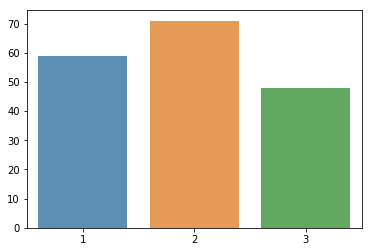

In [5]:
sns.barplot(class_distribution.index, class_distribution.values, alpha=0.8)

In [6]:
X = dataset.loc[ : , "Alcohol":].copy()
y = dataset.loc[ : , "Class"].copy()

We apply hierarchical clustering using single linkage. Given that there are 150 cases, we have 149 merges.

In [7]:
merges = linkage(X, method = 'single')
print('there have been %d merges'%(merges.shape[0]))

there have been 177 merges


Let's plot the dendrogram which shows two major clusters: a smaller one (in green) and a larger one.

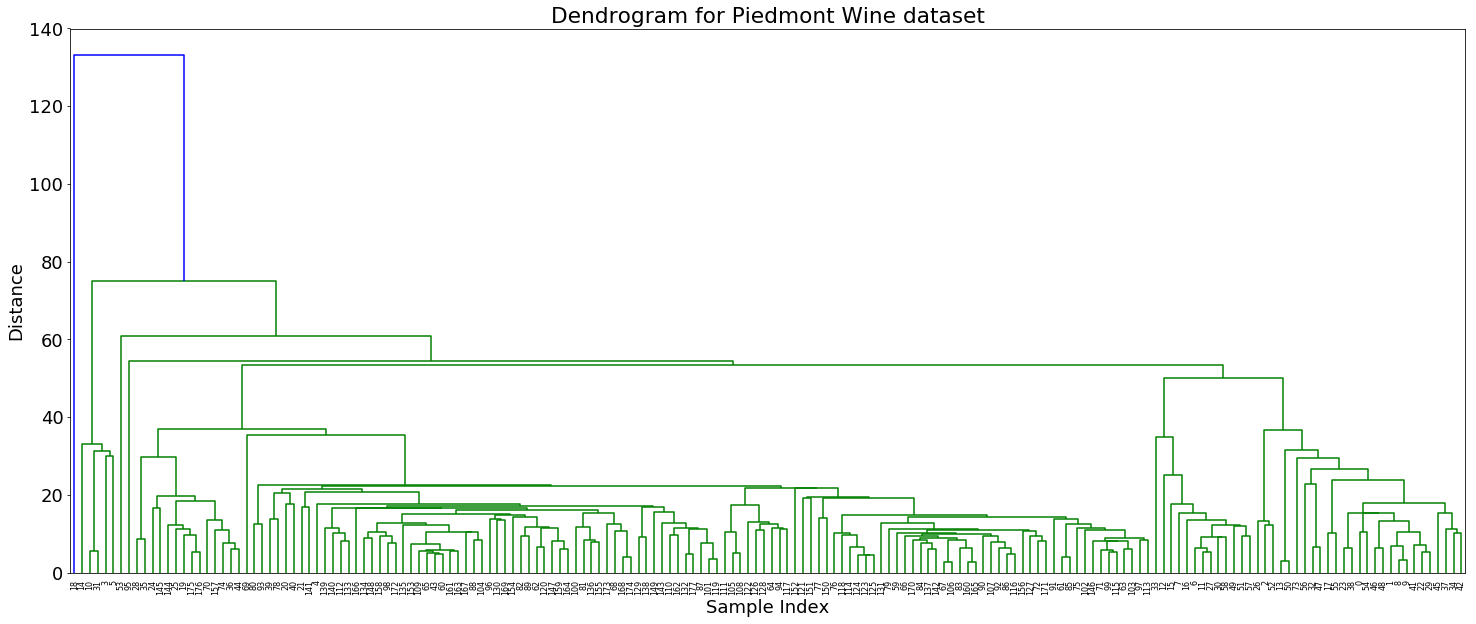

In [8]:
plt.figure(figsize=(25, 10))
font = {'family' : 'sans', 'size'   : 18}
plt.rc('font', **font)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(merges, 
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.title('Dendrogram for Piedmont Wine dataset')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

## Internal Measures
We evaluate the possible clustering by analyzing the withing sum of squares (WSS) and the between sum of squares of the different clustering solutions.


In [9]:
def ComputeInternalMeasures(x, merges, k_values):
    wss_values = {}
    bss_values = {}

    for k in k_values:
        clustering = fcluster(merges, k, criterion='maxclust')
        centroids = [np.mean(x[clustering==c],axis=0) for c in range(1,k+1)]
        cdist(x, centroids, 'euclidean')
        D = cdist(x, centroids, 'euclidean')
        cIdx = np.argmin(D,axis=1)
        d = np.min(D,axis=1)

        avgWithinSS = sum(d)/x.shape[0]

        # Total with-in sum of square
        wss = sum(d**2)

        tss = sum(pdist(x)**2)/x.shape[0]

        bss = tss-wss

        wss_values[k] = wss
        bss_values[k] = bss
    return wss_values,bss_values

In [10]:
k_values = range(1,20)
wss_dict, bss_dict = ComputeInternalMeasures(X, merges, k_values)

In [11]:
wss_values = [wss_dict[x] for x in range(1,20)]
bss_values = [bss_dict[x] for x in range(1,20)]

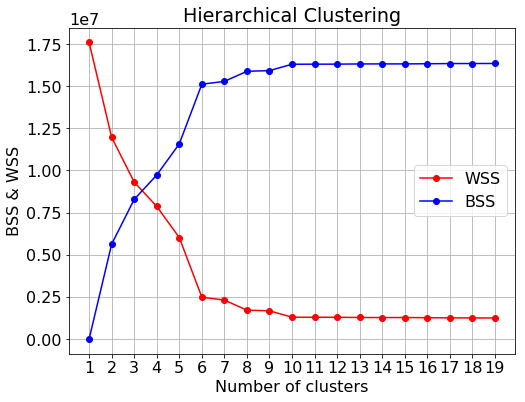

In [12]:
fig = plt.figure(figsize=(8,6))
font = {'family' : 'sans', 'size'   : 16}
plt.rc('font', **font)
plt.plot(k_values, wss_values, 'bo-', color='red', label='WSS')
plt.plot(k_values, bss_values, 'bo-', color='blue', label='BSS')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('BSS & WSS')
plt.xticks(k_values)
plt.legend()
plt.title('Hierarchical Clustering');

There is an elbow around k=6. We should now use the elbow as a guide and test some solutions around that value.

## External Meaures
Let's evaluate the solution with three clusters and compute a table that report the distribution of original labels in each one of the three clusters so that we can compare the clustering solution against the known labels.

In [13]:
labels_single_k6 = fcluster(merges,6,criterion='maxclust')
df = pd.DataFrame({'Cluster': labels_single_k6, 'Class': dataset['Class']})

# Create crosstab: ct
ct = pd.crosstab(df['Cluster'],df['Class'])

# Print the table
print(ct)

Class     1   2   3
Cluster            
1         5   0   0
2        13  69  48
3        39   1   0
4         0   1   0
5         1   0   0
6         1   0   0


As we can see only part of the data points belonging to class 1 are separated in cluster 1, 2, and 3. Elements of class 2 and 3 remain in cluster 2 mixed with elements of class 1.

## Hierarchical Clustering using Normalized Data
We now repeat the same process on the normalized data. For this purpose, we first apply StandardScaler to the data and then repeat the above procedure.

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


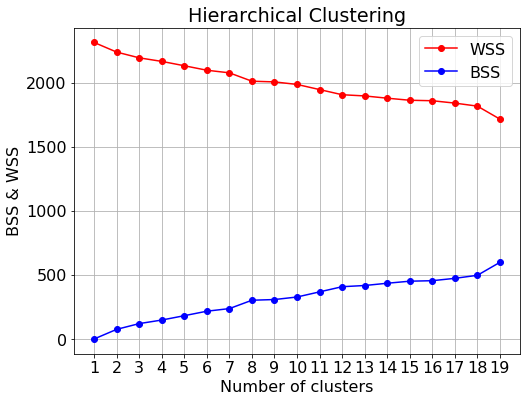

In [14]:
# normalize the data
scaler = StandardScaler()
norm_X = scaler.fit_transform(X)

# apply hierarchical clustering
norm_merges = linkage(norm_X, method = 'single')

# evaluating the possible clustering
k_values = range(1,20)
wss_dict, bss_dict = ComputeInternalMeasures(norm_X, norm_merges, k_values)
wss_values = [wss_dict[x] for x in range(1,20)]
bss_values = [bss_dict[x] for x in range(1,20)]
fig = plt.figure(figsize=(8,6))
font = {'family' : 'sans', 'size'   : 16}
plt.rc('font', **font)
plt.plot(k_values, wss_values, 'bo-', color='red', label='WSS')
plt.plot(k_values, bss_values, 'bo-', color='blue', label='BSS')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('BSS & WSS')
plt.xticks(k_values)
plt.legend()
plt.title('Hierarchical Clustering');

Note that we cannot identify any interesting edge or elbow.